# Project 1 TAA - SVM Model

In [2]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#to load matlab mat files
from scipy.io import loadmat

#SVC
from sklearn.svm import SVC

In [2]:
filename = "../datasets/train/fear_angry_surprise_neutral.mat"
mat=loadmat(filename)

# mat is a dict with key "X" for x-values, and key "y" for y values
X=mat["X"]
y=mat["y"]

filename = "../datasets/dev/fear_angry_surprise_neutral.mat"
mat=loadmat(filename)

# mat is a dict with key "X" for x-values, and key "y" for y values
Xval=mat["X"]
yval=mat["y"]

filename = "../datasets/test/fear_angry_surprise_neutral.mat"
mat=loadmat(filename)

# mat is a dict with key "X" for x-values, and key "y" for y values
Xtest=mat["X"]
ytest=mat["y"]

#number of training examples
m = len(X)

print(f"Loaded {X.shape[0]} traing examples, each with {X.shape[1]} features (pixels).")
print(f"Loaded {Xval.shape[0]} validation examples, each with {X.shape[1]} features (pixels).")

Loaded 4000 traing examples, each with 2304 features (pixels).
Loaded 800 validation examples, each with 2304 features (pixels).


In [3]:
def dataset3Params(X, y, Xval, yval,vals_C, vals_gamma):
    """
    dataset3Params returns the optimal C and gamma(1/sigma) based on a cross-validation set.
    """
    acc = 0
    best_C=0
    best_gamma=0
    scores_hist=[]
    for C in vals_C:
        for gamma in vals_gamma:
            classifier = SVC(C=C,gamma=gamma)
            classifier.fit(X,y)
            prediction = classifier.predict(Xval)
            score = classifier.score(Xval,yval)
            scores_hist.append((C,gamma,score))
            if score>acc:
                acc =score
                best_C =C
                best_gamma=gamma
    return best_C, best_gamma,scores_hist

### Best C and gamma

https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769


In [39]:
vals_C = [0.001, 0.01, 0.1, 1, 10, 100]
vals_gamma = [0.001, 0.01, 0.1, 1, 10, 100]
best_C, best_gamma, scores_hist= dataset3Params(X, y.ravel(), Xval, yval.ravel(),vals_C,vals_gamma)

#What are the best C and sigma ?
print("Best C " + str(best_C) + " Best Gamma " + str(best_gamma))

Best C 10 Best Gamma 0.01


(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

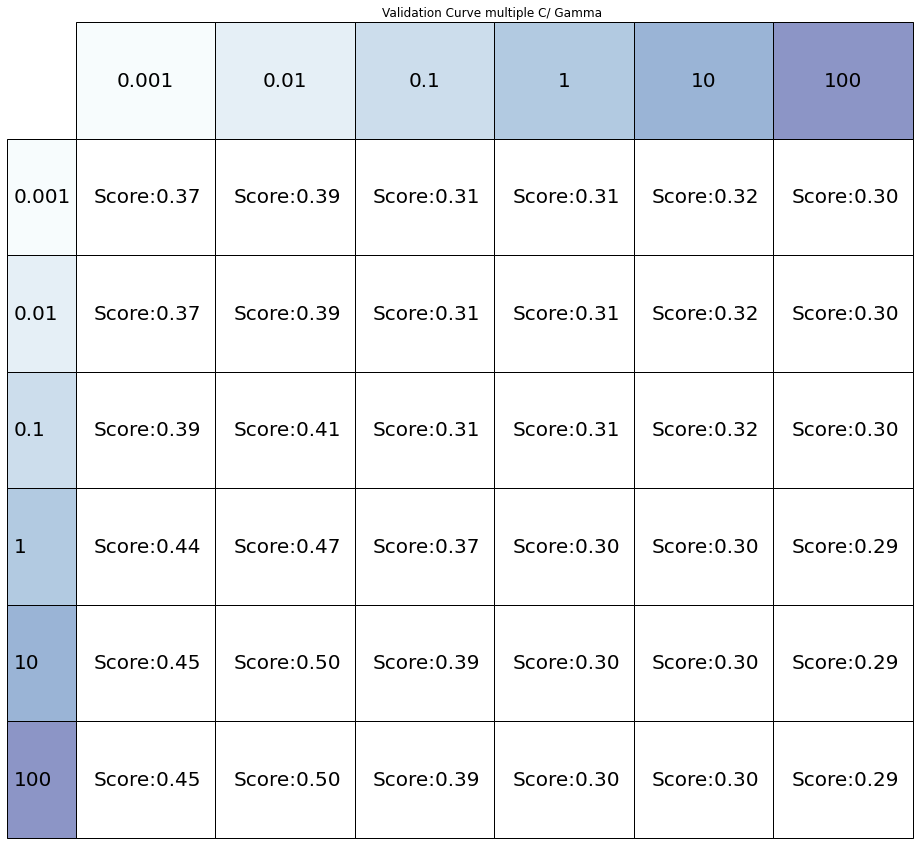

In [40]:
n= len(vals_C)
m=len(vals_gamma)

data = np.array([f'Score:{score[2]:.2f}' for score in scores_hist]).reshape((n,m))

plt.figure(figsize=(15,15))

colors = plt.cm.BuPu(np.linspace(0, 0.5, n))
colorsCols = plt.cm.BuPu(np.linspace(0, 0.5, m))
the_table = plt.table(cellText=data,rowLabels=vals_C,rowColours=colors,colLabels=vals_gamma, colColours=colorsCols, loc='center',bbox=[0.0,0,1,1])
the_table.set_fontsize(20)
plt.title("Validation Curve multiple C/ Gamma ")
plt.axis('off')
plt.axis('tight')

In [41]:
#Build an SVM classifier with the best C and gamma and get classifier score of about 95% ?
classifier = SVC(gamma=best_gamma,C=best_C, kernel="rbf")

# Merge validation and train datasets and get error
X_train_dev= np.concatenate((X,Xval))
y_train_dev= np.concatenate((y,yval))

classifier.fit(X_train_dev,np.ravel(y_train_dev))
print(classifier.score(Xtest,ytest))

0.4525


In [42]:
import json

scores={'score_hist':scores_hist}
with open('score_fear_angry_surprise_neutral.json', 'w') as json_file:
    json.dump(scores, json_file)

In [3]:
classifier = SVC(gamma=0.01,C=10, kernel="rbf")

filename = "../datasets/train/angry_fear_happy_neutral_sad_surprise.mat"
mat=loadmat(filename)

# mat is a dict with key "X" for x-values, and key "y" for y values
X=mat["X"]
y=mat["y"]

filename = "../datasets/dev/angry_fear_happy_neutral_sad_surprise.mat"
mat=loadmat(filename)

# mat is a dict with key "X" for x-values, and key "y" for y values
Xval=mat["X"]
yval=mat["y"]

filename = "../datasets/test/angry_fear_happy_neutral_sad_surprise.mat"
mat=loadmat(filename)

# mat is a dict with key "X" for x-values, and key "y" for y values
Xtest=mat["X"]
ytest=mat["y"]

# Merge validation and train datasets and get error
X_train_dev= np.concatenate((X,Xval))
y_train_dev= np.concatenate((y,yval))

classifier.fit(X_train_dev,np.ravel(y_train_dev))
print(classifier.score(Xtest,ytest))

0.4141666666666667


In [4]:
pred2=classifier.predict(Xtest)

In [5]:
def confusionMatrix(emotions, pred, y):
    
    confusionTFPN = {}
    confusionWithOtherEmotions = {}
    
    # Foreach emotion
    for ie in range(len(emotions)):
        # TRUE AND FALSE POSITIVES AND NEGATIVES (TFPN)
        
        # Get indexes where emotion was predicted
        ieIndexesPred = [i for i in range(pred.size) if pred[i]==ie]
        ieIndexesNotPred = [i for i in range(pred.size) if pred[i]!=ie]

        # Predicted, and Actual
        TP = sum(pred[:,np.newaxis][ieIndexesPred]==y[ieIndexesPred])
        # Predicted, but not actual
        FP = sum(pred[:,np.newaxis][ieIndexesPred]!=y[ieIndexesPred])
        # Not predicted, but actual
        FN = sum(y[ieIndexesNotPred]==ie)
        # Not predicted and not actual
        TN = sum(y[ieIndexesNotPred]!=ie)

        TP = TP[0] if TP else 0
        FP = FP[0] if FP else 0
        FN = FN[0] if FN else 0
        TN = TN[0] if TN else 0
        
        confusionTFPN[emotions[ie]] = {
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN
        }
        
        # CONFUSION WITH OTHER EMOTIONS (Confusion)
        # For emotion e
        # Count the number of predictions made for all classes
        # Foreach emotion, check how many times it has been predicted 
        
        # Get indexes where emotion is real
        ieIndexesY = [i for i in range(y.size) if y[i]==ie]
        
        # Foreach matching prediction, check what emotion was predicted
        confusionWithOtherEmotions[emotions[ie]] = {
            e: sum(pred[:,np.newaxis][ieIndexesY]==emotions.index(e))[0] for e in emotions
        }
        
    return confusionTFPN, confusionWithOtherEmotions        

In [15]:
def outputConfusionTables(emotions, y, confusionTFPN, confusionWithOtherEmotions, axs, axsLine):
      # TABLES
    rows = tuple(emotions)
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    
    # TABLES / TFPN
    # Output confusion matrix as plot table
    testExamplesNumber = y.size
    data = [
        [
            f"{vals['TP']} ({vals['TP']/testExamplesNumber*100:.2f}%)",
            f"{vals['TN']} ({vals['TN']/testExamplesNumber*100:.2f}%)",
            f"{vals['TP']+vals['TN']} ({(vals['TP']+vals['TN'])/testExamplesNumber*100:.2f}%)",
            f"{vals['FP']} ({vals['FP']/testExamplesNumber*100:.2f}%)",
            f"{vals['FN']} ({vals['FN']/testExamplesNumber*100:.2f}%)",
            f"{vals['FP']+vals['FN']} ({(vals['FP']+vals['FN'])/testExamplesNumber*100:.2f}%)",
            vals['FP']+vals['FN']+vals['TP']+vals['TN']
        ]
        for _, vals in confusionTFPN.items()
    ]
    columns = ['TP (%)', 'TN (%)', 'T (%)', 'FP (%)', 'FN (%)', 'F (%)', f"Total"]
    
    # Colorize cells depending on value 
    cellColoursTF=plt.cm.Blues([
        [ (vals['TP']+vals['TN'])/testExamplesNumber, (vals['FP']+vals['FN'])/testExamplesNumber ] for _, vals in confusionTFPN.items()
    ])
    cellColourPos=plt.cm.Greens([
        [ vals['TP']/(vals['TP']+vals['FP']), vals['FP']/(vals['TP']+vals['FP']) ] for _, vals in confusionTFPN.items()
    ])
    cellColourNeg=plt.cm.Reds([
        [ vals['TN']/(vals['TN']+vals['FN']), vals['FN']/(vals['TN']+vals['FN']) ] for _, vals in confusionTFPN.items()
    ])
    
    cellColours = [
        [
            cellColourPos[i][0],
            cellColourNeg[i][0],
            cellColoursTF[i][0],
            cellColourPos[i][1],
            cellColourNeg[i][1],
            cellColoursTF[i][1],
            [0, 0, 0, 0]
        ]
        for i in range(len(rows))
    ]
        
    the_table = axs[axsLine].table(
      cellText=data,
      rowLabels=rows,
      colLabels=columns,
      loc='center',
      cellColours=cellColours
    )
    # the_table.scale(1, 2)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(20)
    axs[axsLine].axis('off')
    axs[axsLine].axis('tight')
    axs[axsLine].set_title(f"Confusion matrix ")    
    
    # TABLES / Confusion    
    # Output confusion matrix as plot table
    data = [[o for _,o in others.items()] for _,others in confusionWithOtherEmotions.items()]
    columns = rows
    
    # Colorize cells depending on value
    vals = [o for _,others in confusionWithOtherEmotions.items() for _,o in others.items()]
    normal = plt.Normalize(min(vals)-1, max(vals)+1)
    cellColours=plt.cm.Blues(normal(data))
        
    the_table = axs[axsLine+1].table(
      cellText=data,
      rowLabels=rows,
      colLabels=columns,
      loc='center',
      cellColours=cellColours
    )
    the_table.set_fontsize(20)
    # the_table.scale(1, 3)
    axs[axsLine+1].axis('off')
    axs[axsLine+1].axis('tight')
    axs[axsLine+1].set_title(f"True/Predicted")

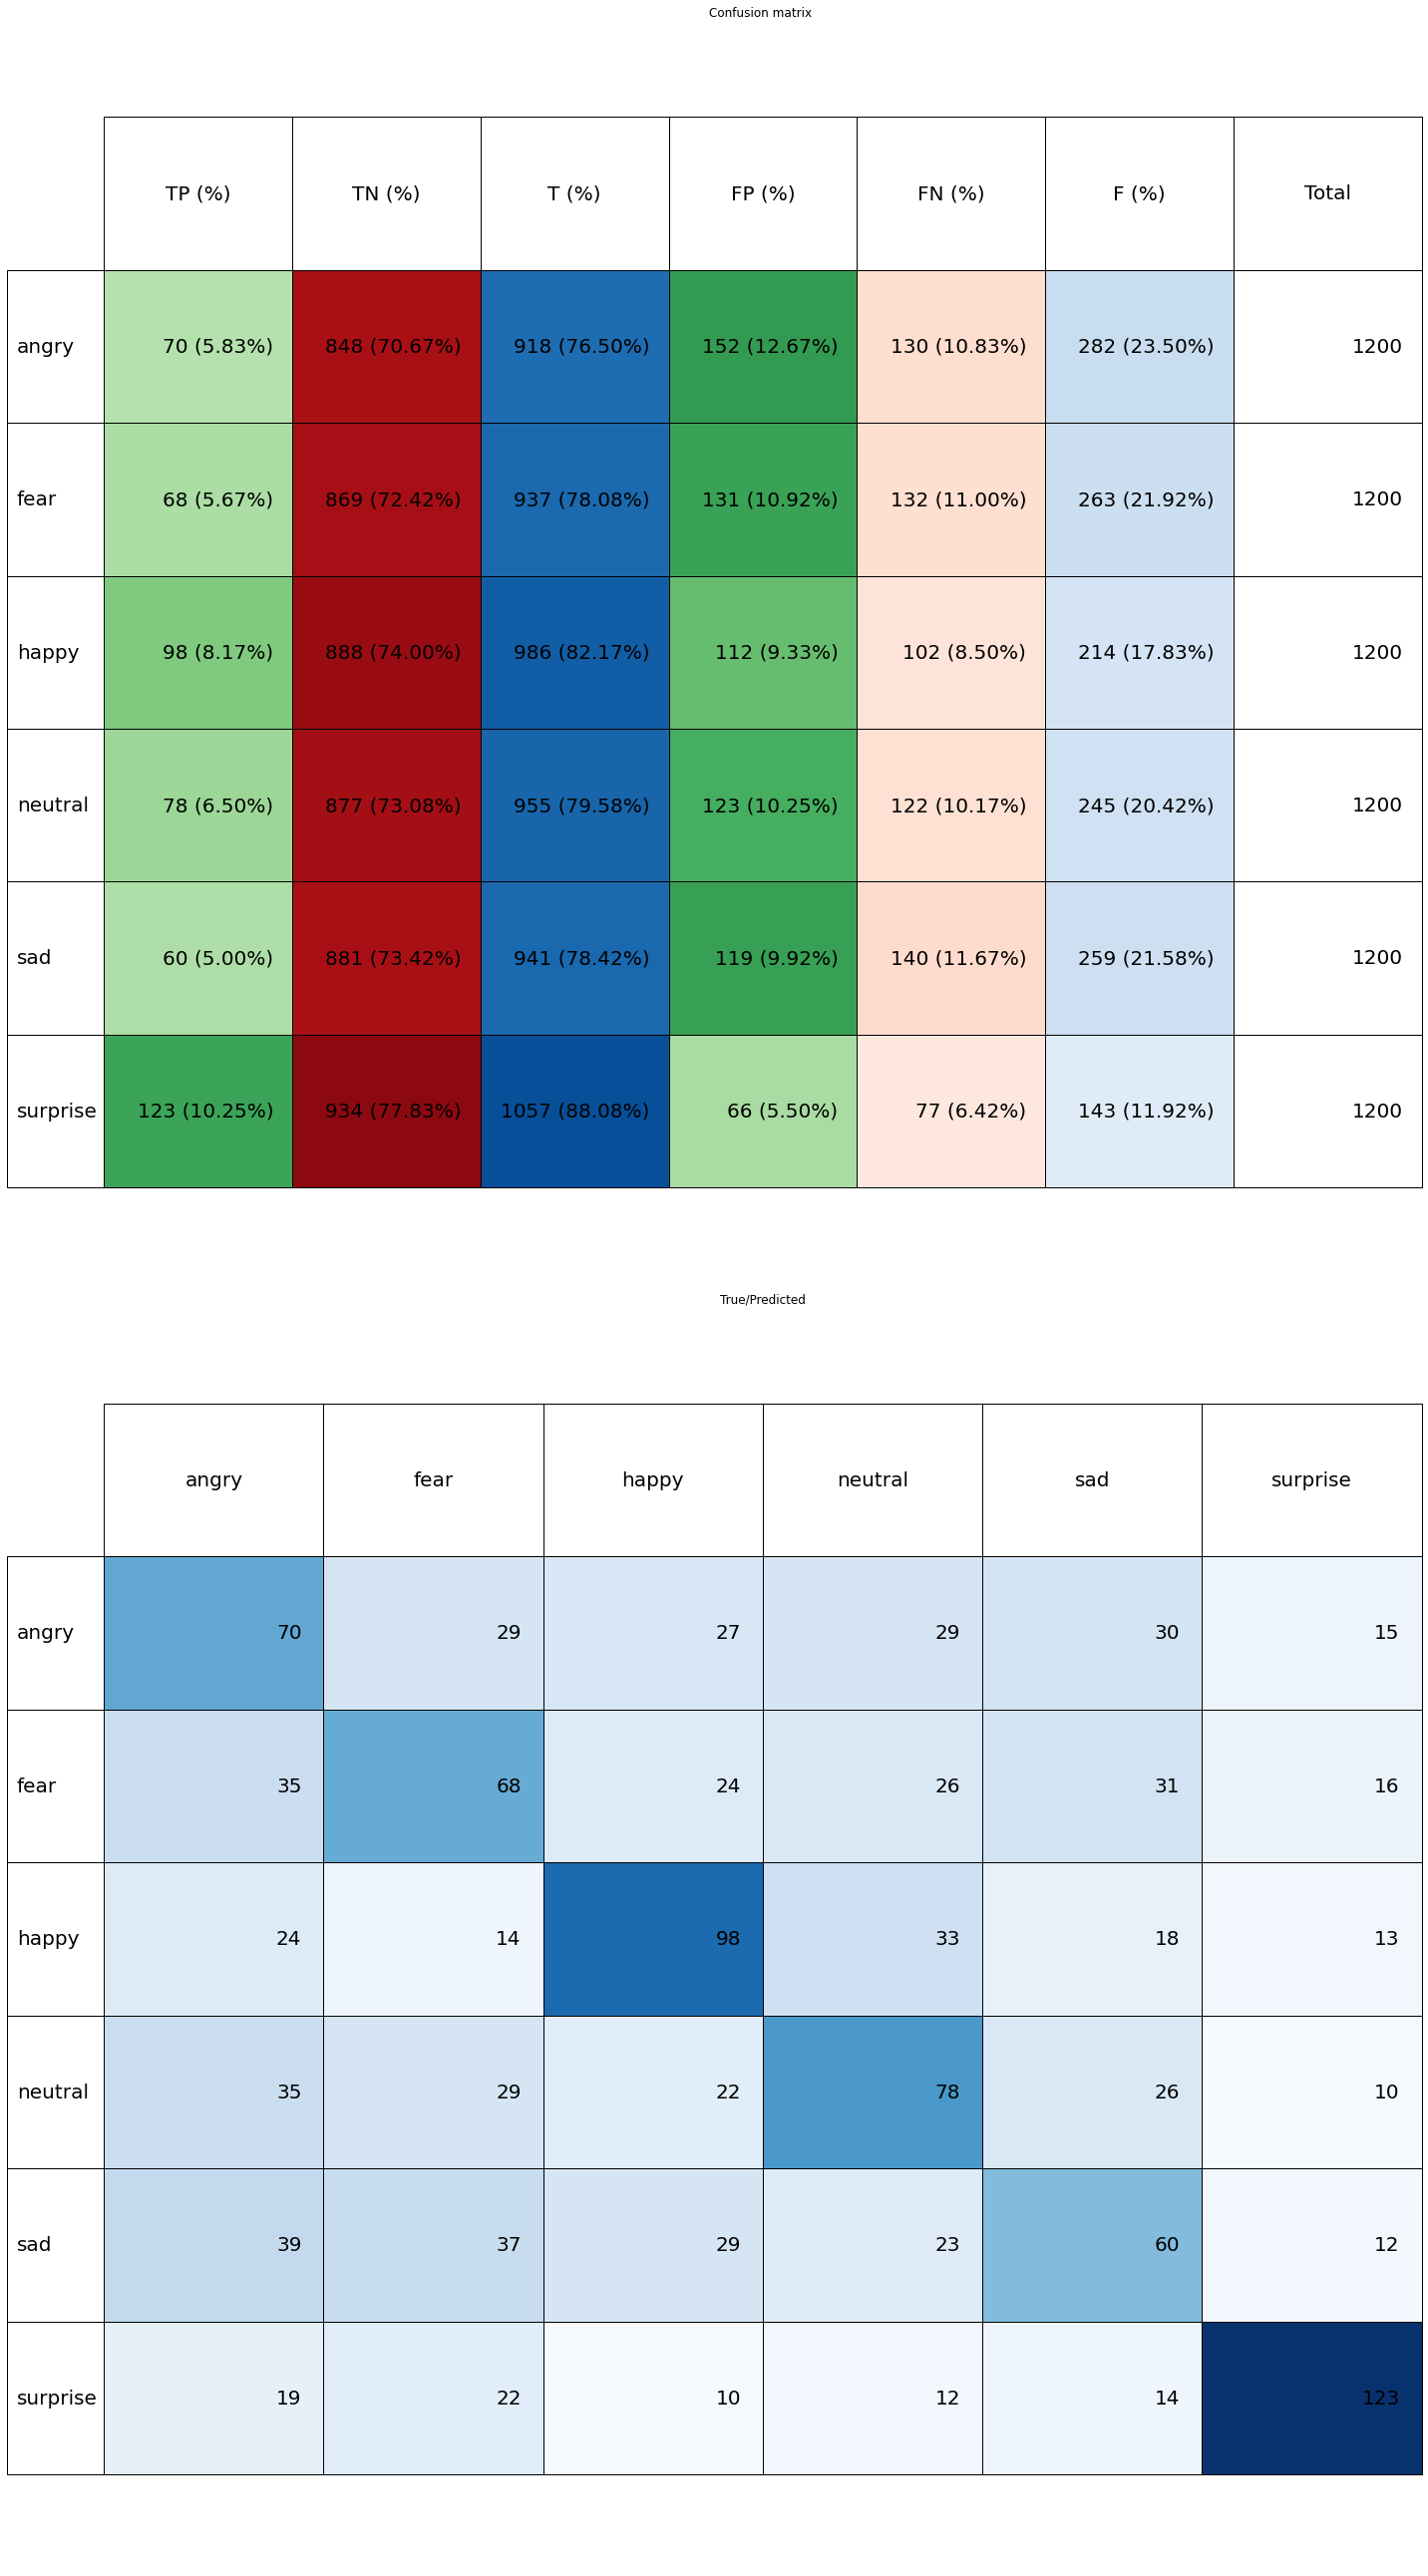

In [26]:
emotions = ["angry","fear","happy","neutral","sad","surprise"]
confusionTFPN, confusionWithOtherEmotions= confusionMatrix(emotions, pred2, ytest)  


fig, axs = plt.subplots(2,1)
outputConfusionTables(emotions, ytest, confusionTFPN, confusionWithOtherEmotions, axs, 0 )

fig.set_size_inches(20,36)
fig.subplots_adjust(left=0.2, top=2)
fig.tight_layout()
fig.savefig(f"./metrics/analysis.png")



0.3333333333333333
(18, 2304)


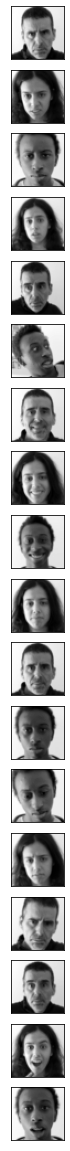

In [27]:
filename = "../datasets/home_made/angry_fear_happy_neutral_sad_surprise.mat"
mat=loadmat(filename)

# mat is a dict with key "X" for x-values, and key "y" for y values
Xtest=mat["X"]
ytest=mat["y"]

print(classifier.score(Xtest,ytest))

labels=6
labelNames=emotions
fig, axis = plt.subplots(18,1,figsize=(2,18))
fig.subplots_adjust(top=1)

print(Xtest.shape)
# Foreach label, output 10 random images
for i in range(18):
    # Show image
    axis[i].imshow(Xtest[i,:].reshape(48,48,order="F").T, cmap="gray") 
    # Hide axes
    axis[i].set_xticks([])
    axis[i].set_yticks([])
